## The Model

In [1]:
# Standard packages
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from generate_features import generate_features
from transformations import random_undersample

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the data.

df_transactions = pd.read_pickle('dataframes/df_transactions.pkl')
df_users = pd.read_pickle('dataframes/df_users.pkl')
df_fx = pd.read_pickle('dataframes/df_fx.pkl')
df_currency = pd.read_pickle('dataframes/df_currency.pkl')

First we undersample the majority class. This is a skewed classification and it has been shown that a very simple way to increase performance for skewed classification tasks is to undersample the majority class.

In [3]:
df_users_undersample = random_undersample(df_users)

X, y = generate_features(df_transactions=df_transactions,
                         df_users=df_users_undersample,
                         df_fx=df_fx,
                         df_currency=df_currency,
                         df_countries=None,
                         test_time = False)

Text(0.5,1,'Balanced Subsample')

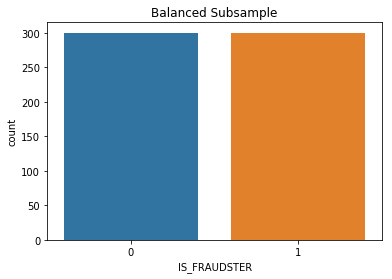

In [4]:
sns.countplot(y)
plt.title('Balanced Subsample')

In [5]:
# This is what the data looks like now after going through the full transformation process 
# Please see transformations.py for more details

X[:5] 

array([[-0.24124895, -0.37507921,  0.51039612, -0.17076159, -1.34176156,
        -1.50361882, -0.29153209, -0.17586311,  1.31898674, -0.33333333,
        -0.14881703, -0.82502865,  2.86893172,  0.33333333,  0.79613457,
        -0.34251779, -0.93228691],
       [-0.24124895, -0.37507921,  0.51039612, -0.17076159,  0.17150336,
        -1.50361882,  3.43015414, -0.17586311, -0.75815773, -0.33333333,
        -0.14881703, -0.82502865, -0.3485618 ,  0.33333333, -0.5558682 ,
        -0.34251779, -0.93228691],
       [-0.24124895, -0.37507921,  0.51039612, -0.17076159, -1.53091968,
         0.66506217, -0.29153209, -0.17586311,  1.31898674, -0.33333333,
        -0.14881703, -0.82502865,  2.86893172,  0.33333333, -0.63082033,
        -0.34251779, -0.93228691],
       [-0.24124895, -0.37507921,  0.51039612, -0.17076159, -0.67970816,
        -1.50361882, -0.29153209, -0.17586311,  1.31898674, -0.33333333,
        -0.14881703, -0.82502865, -0.3485618 ,  0.33333333, -0.5723965 ,
        -0.34251779

### PCA and t-SNE preliminary analysis

In [6]:
tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
pca = PCA(n_components=2, random_state=42).fit_transform(X)

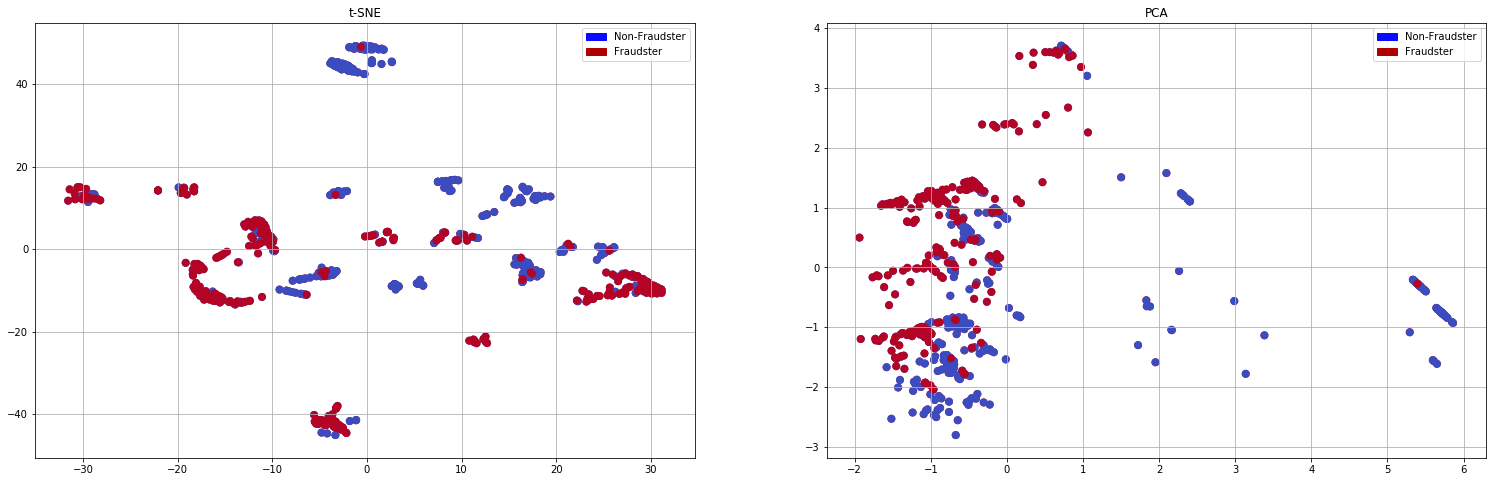

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 8))

blue = matplotlib.patches.Patch(color='#0A0AFF', label='Non-Fraudster')
red = matplotlib.patches.Patch(color='#AF0000', label='Fraudster')

ax1.scatter(tsne[:, 0], tsne[:, 1], c=(y==0), cmap='coolwarm', label='Non-Fraudster', linewidths=2)
ax1.scatter(tsne[:, 0], tsne[:, 1], c=(y==1), cmap='coolwarm', label='Fraudster', linewidths=2)
ax1.set_title('t-SNE')
ax1.grid(True)
ax1.legend(handles=[blue, red])

ax2.scatter(pca[:,0], pca[:,1], c=(y==0), cmap='coolwarm', label='Non-Fraudster', linewidths=2)
ax2.scatter(pca[:,0], pca[:, 1], c=(y==1), cmap='coolwarm', label='Fraudster', linewidths=2)
ax2.set_title('PCA')
ax2.grid(True)
ax2.legend(handles=[blue, red])

After some experimentation with the visualzations created by PCA -- which projects the high dimensional data down into smaller dimensions while maximizing the variance such that we retain as much information as possible, and t-SNE -- manifold learning in high dimension space (a very different type of decomposition than PCA that will show us if there exists any high-dimensional manifolds that can be 'unrolled'), I discovered that CREATED_DATE is really not a useful feature and is adding a lot of noise so I've dropped that now (it's no longer a part of X). Without that feature, we now see there is definitely some distinction between the positive and negative class so we can expect an ML model to be able to learn at least a decent decision boundary and be able to seperate the data.

### Try some simple classifiers

Remember the data is undersampled. Without doing this, there is simply too much noise from the non-negative examples that will drown out the classifier's ability to pick a seperating boundary (or boundaries in the case of tree-based classifier). However, the big downside of random undersampling is the risk of overfitting (high variance) the training set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train, y_test = y_train.values, y_test.values

In [9]:
classifiers = {
    'LR': LogisticRegression(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(),
    'RF': RandomForestClassifier(),  
}

In [10]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    val_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(key, ' val score is', round(val_score.mean(), 2) * 100, '% accuracy')

LR  val score is 84.0 % accuracy
SVM  val score is 87.0 % accuracy
KNN  val score is 87.0 % accuracy
DT  val score is 80.0 % accuracy
RF  val score is 85.0 % accuracy


Note: Since we've undersampled the majority class and turned this into a balanced classification task, accuracy is a good metric to use. If we were still dealing with high skew in the classes, another metric such as AUC or F1 would be a better option (both based on precision/recall scores which are derived from the confusion matrix (i.e. TPR/FNR)).

But overall this pretty good given we haven't even searched for hyperparameters yet and the features we're using are quite basic and more advanced data analysis in part 3A could probably imporove the result at this stage greatly.

SVM and LR are showing great promise. I will drop the DT in favor of RF so there will be only 4 classifier for which I do grid search: LR, SVM, KNN, RF.

### Hyperparameter Optimization: Grid Search

Randomized search is generally a better option for when there are many hyperparameters to tune but for this project, 
I will keep it simple and just tune a few and therefore just grid search should suffice.

For Logistic Regression, we will check penalty (l1 is manhattan distance, l2 is euclidean norm), regularization strength, and tolerance.

In [11]:
lr_params = {'penalty': ['l1', 'l2'],
                  'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  'tol':[1e-8, 1e-6, 1e-4]}

lr_grid = GridSearchCV(LogisticRegression(), lr_params)
lr_grid.fit(X_train, y_train)
lr_best, lr_params_best = lr_grid.best_estimator_, lr_grid.best_params_

For SVM, we check C with specifies the 'softness' of the margin (larger C focuses on correctly seperating instances over maximizing the margin (i.e. maximizing the distance from the margin to the support vectors)), as well as kernels which allow SVM to create non-linear decision boundaries via the kernel trick. The kernels we try are RBF (radial basis function), polynomial, sigmoid and linear (which is the default).

In [12]:
svm_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

svm_grid = GridSearchCV(SVC(), svm_params)
svm_grid.fit(X_train, y_train)
svm_best, svm_params_best = svm_grid.best_estimator_, svm_grid.best_params_

Now comes the simple but powerful KNN classifier. The n_neighbors parameter is self-explanatory. The algorithm parameter is the algorithm actually used to compute the neighbors.

In [13]:
knn_params = {'n_neighbors': list(range(1, 10)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params)
knn_grid.fit(X_train, y_train)
knn_best, knn_params_best = knn_grid.best_estimator_, knn_grid.best_params_

And last but certainly not least, the reputable Random Forests classifier. This classifier is an ensemble of decision trees. The parameters we check are: gini vs entropy for the information gain (i.e. what decision tree splits are based on -- the decision (i.e. choice of attribute) that maximizes the information gain at each split. See the ID3 algorithm for more information (no pun itended)). The other parameters are self-explanatory.

In [14]:
rf_params = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 1, 2, 3], 
            'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3]}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params)
rf_grid.fit(X_train, y_train)
rf_best, rf_params_best = rf_grid.best_estimator_, rf_grid.best_params_

Let's look at the scores now:

In [15]:
print('Validation scores')

lr_score = cross_val_score(lr_best, X_train, y_train, cv=5)
print('Logistic Regression: ', round(lr_score.mean(), 2) * 100, '% accuracy')

knn_score = cross_val_score(knn_best, X_train, y_train, cv=5)
print('KNN: ', round(knn_score.mean(), 2) * 100, '% accuracy')

svm_score = cross_val_score(svm_best, X_train, y_train, cv=5)
print('SVM: ', round(svm_score.mean(), 2) * 100, '% accuracy')

rf_score = cross_val_score(rf_best, X_train, y_train, cv=5)
print('Random Forests: ', round(rf_score.mean(), 2) * 100, '% accuracy')

Validation scores
Logistic Regression:  85.0 % accuracy
KNN:  87.0 % accuracy
SVM:  87.0 % accuracy
Random Forests:  85.0 % accuracy


In [16]:
# Look at best params for LR:

print('best_paramters :', lr_params_best)

best_paramters : {'C': 0.01, 'penalty': 'l2', 'tol': 1e-08}


Note how the best parameters are wildly different from the default LR settings. In particular, it found that using the manhattan distance as a norm penalty over the default euclidean distance resulted in better results. L1 norm has the tendencing of creating a sparse model (i.e. one with weights zeroed out). This might mean we have features that aren't relevant but the L1 norm is taking care of the irrelevant features for us by zeroing them out.

The tolerance was also decreased from the default 1e-4 or 1e-8 and regularization strength was decreased (since C is the inverse of regiularization stength -- increasing it reduces regularization). 

Evaluate on test set:

In [17]:
print('Test scores')

print('Logistic Regression: ', round(lr_best.score(X_test, y_test), 2) * 100, '% accuracy')
print('KNN: ', round(knn_best.score(X_test, y_test), 2) * 100, '% accuracy')
print('SVM: ', round(svm_best.score(X_test, y_test), 2) * 100, '% accuracy')
print('Random Forests: ', round(rf_best.score(X_test, y_test), 2) * 100, '% accuracy')

Test scores
Logistic Regression:  92.0 % accuracy
KNN:  90.0 % accuracy
SVM:  90.0 % accuracy
Random Forests:  89.0 % accuracy


In [18]:
## Train the final classifier on full training set and save to disk:

lr_best_full = LogisticRegression(**lr_params_best).fit(X, y)
svm_best_full = SVC(**svm_params_best).fit(X, y)
knn_best_full = KNeighborsClassifier(**knn_params_best).fit(X, y)
rf_best_full = RandomForestClassifier(**rf_params_best).fit(X, y)

# with open('lr_clf.pkl', 'wb') as f:
#     pickle.dump(lr_best_full, f)
    
# with open('svm_clf.pkl', 'wb') as f:
#     pickle.dump(svm_best_full, f)
    
# with open('knn_clf.pkl', 'wb') as f:
#     pickle.dump(knn_best_full, f)
    
# with open('rf_clf.pkl', 'wb') as f:
#     pickle.dump(rf_best_full, f)

## Conclusion

So it seems that they're all quite similar but Logistic Regression and SVM have the slight edge. I will choose the logistic regression model because it has a nice probability output (thanks to it's sigmoid activation) and this will be useful for the next part where I will decide on which action to take (Lock, Alert Agent, Both).

Also, I want to note the analysis towards the end here was a bit rushed as I'm running out of time now (Christmas holidays really took up more of my time than expected). Normally, here I would plot learning curves to try to analyze how much overfitting/underfitting is going on and adjusting to correct that. Also, further enhancemants such as implementing synthetic over-sampling tehhniques like SMOTE have been very successful for me in my projects at BBC that also involve dealing with unbalanced classfication tasks. This is something that can definitely implemented here as well and it would likely improve results. 

Also, most importantly, there is still a wealth of information to explore in the data, in particular the transactions table, which I only touched the surface of. The clear next step in this project would be to actually take a step back and resume the data exploration and feature engineering phase and try to extract some more useful features because I'm sure there are some just waiting to be found. Furthermore, just a general suggestion would be to implement ensembling (with classifiers that make different kinds of mistakes) as this almost always helps.

With all of these things, I'm sure a test accuracy of over 95% is achievable but I simply do not have the time right now unfortunately. But hey, ~90% with the logistic regression model isn't too shabby (even if this is the case of undersampled majority class so we can expect the true accuracy in an online streaming setting with no such balance to be not as great, but this still better for identifying fraudsters than what we would achieve if we passed in the unbalanced dataset). Again, to combat this, techniques such as SMOTE would be valuable and other more advanced synthetic sample creation methods.


<b>UPDATE: After further investigation, I've chosen the random forest model as the final model. I found it to work much better than the logistic regression model in the unbalanced label setting while the balanced setting scores are negligible as can be seen above.</b>

### Bonus

For fun, let's just see exactly how bad the scores are when passing in the unbalanced data to the logistic regression classifier:

In [19]:

# Removed model training code for brevity. I'll just print the results:

f1_score = 0.35714285714285715 

print('F1 score when passing in data with no undersampling:', round(f1_score, 2)*100, '%')



F1 score when passing in data with no undersampling: 36.0 %


The accuracy was 97% but the F1 score (the proper metric to use when dealing with an unbalanced dataset) is a mere 36% compared to the 92% accuracy achieved by the undersampled model. Quite the difference! The reason for this is that the abundance of the majority class drowns out any patterns that the model can pick up and it relies mostly on just classifying most examples as positive. This 'drowning out' can be clearly seen when looking at PCA or t-SNE visualizations where the majority class will be everywhere and the negative class will be buried underneath, making it very difficult for the model to pick up patterns and create a decision boundary.